best scores:<br>
m23    0.918030 submission-.9408.csv<br>
m11    0.970747 submission-.9463.csv<br>
m9     0.973479 submission-0.9466.csv<br>
m20    0.973934 Submission-.9433.csv<br>
m1     0.974242 submission-.9485.csv<br>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LABELS = ["isFraud"]
all_files = glob.glob("lgbmodels/*.csv")
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    scores[i] = float('.'+all_files[i].split(".")[1])

In [3]:
top = scores.argsort()[::-1]
for i, f in enumerate(top):
    print(i,scores[f],all_files[f])

0 0.9487 lgbmodels\lgb_newfeats-0.9487.csv
1 0.9486 lgbmodels\lgb_newfeat_10fold-0.9486.csv
2 0.9485 lgbmodels\submission-.9485.csv
3 0.9484 lgbmodels\lgb_newfeatures2-0.9484.csv
4 0.948 lgbmodels\submission-.9480.csv
5 0.9475 lgbmodels\submission-0.9475.csv
6 0.9469 lgbmodels\submission-.9469.csv
7 0.9468 lgbmodels\submission-0.9468.csv
8 0.9467 lgbmodels\submission-0.9467.csv
9 0.9466 lgbmodels\submission-0.9466.csv
10 0.9466 lgbmodels\submission-.9466.csv
11 0.9463 lgbmodels\submission-.9463.csv
12 0.946 lgbmodels\submission-.9460.csv
13 0.9459 lgbmodels\submission-.9459.csv
14 0.9457 lgbmodels\submission-.9457.csv
15 0.9454 lgbmodels\submission-.9454.csv
16 0.9452 lgbmodels\submission-.9452.csv
17 0.9452 lgbmodels\submission_.9452.csv
18 0.9451 lgbmodels\submission-.9451.csv
19 0.9438 lgbmodels\Submission-.9438.csv
20 0.9433 lgbmodels\Submission-.9433.csv
21 0.9433 lgbmodels\submission-0.9433.csv
22 0.9429 lgbmodels\Submission-.9429.csv
23 0.9408 lgbmodels\submission-.9408.csv


In [4]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

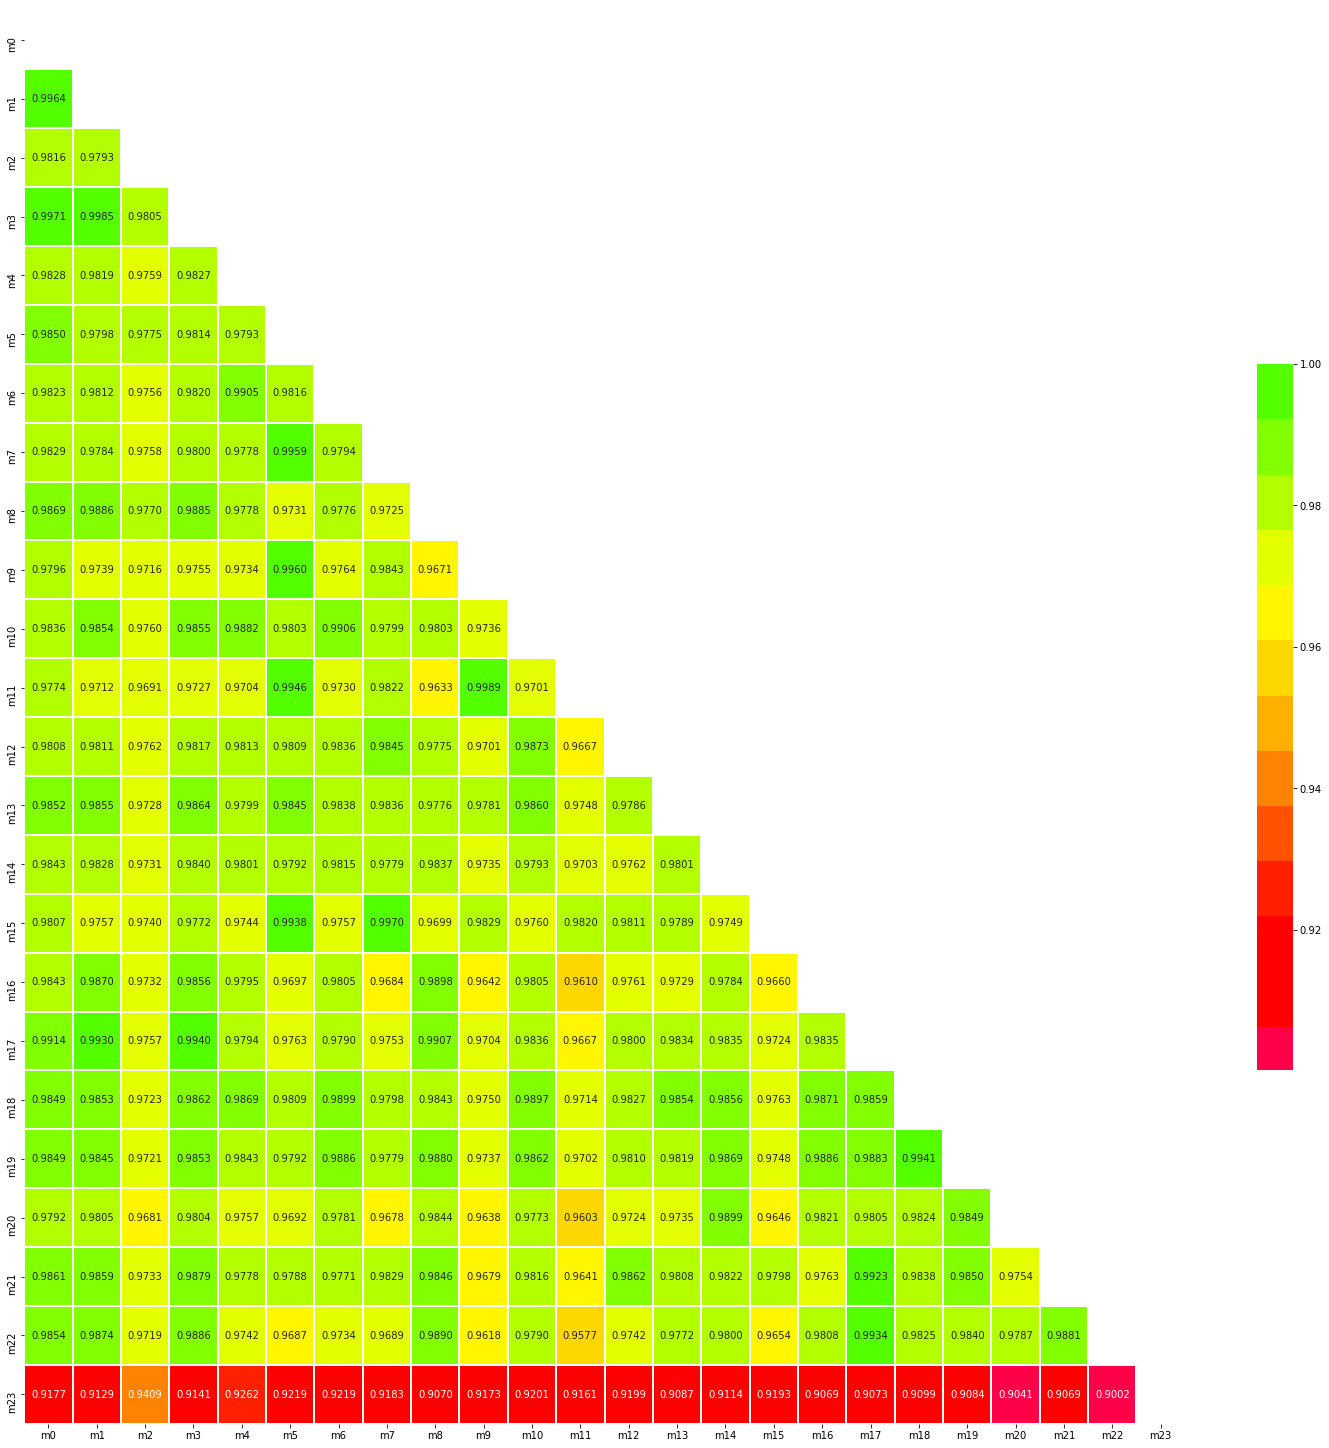

In [5]:
# check correlation
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.5})

In [6]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:5]
mean_corr

# m23    0.918030
# m11    0.970747
# m9     0.973479
# m20    0.973934
# m1     0.974242

m23    0.918221
m11    0.971010
m9     0.973712
m20    0.973884
m2     0.974310
dtype: float64

In [7]:
m_gmean = 0
for n in mean_corr.index:
    m_gmean += np.log(concat_sub[n])
m_gmean = np.exp(m_gmean/len(mean_corr))

In [8]:
top_mean = 0
s = 0
for n in [0,1,4,23]:
    top_mean += concat_sub.iloc[:,n]*scores[top[n]]
    s += scores[top[n]]
top_mean /= s

In [9]:
m_gmean = np.exp(0.4*np.log(m_gmean) + 0.6*np.log(top_mean))

In [10]:
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(9.385851795800488e-05, 0.9985768808125562), mean=0.02564662851031626, variance=0.013020476729619875, skewness=7.020269786866573, kurtosis=50.92062681256987)

In [11]:
concat_sub['isFraud'] = m_gmean
concat_sub[['isFraud']].to_csv('en_results/stack_gmean8.csv')